In [70]:
import numpy as np
import librosa
from scipy.fftpack import dct

import matplotlib.pyplot as plt
import matplotlib as mpl

In [71]:
original_signal, original_sampling_rate = librosa.load("audio.wav")

print("La señal tiene", len(original_signal), "muestras")
print("Y el ratio de muestreo es", original_sampling_rate, "Hz")
print("La señal tiene una duración de", len(original_signal)/original_sampling_rate, "s")

La señal tiene 261728 muestras
Y el ratio de muestreo es 22050 Hz
La señal tiene una duración de 11.869750566893424 s


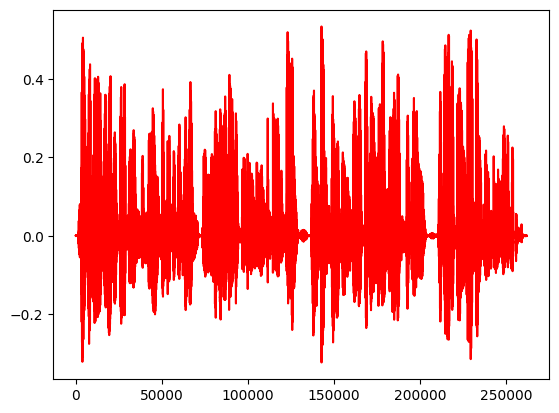

In [72]:
# Vamos a graficar la señal obtenida del archivo
plt.plot(np.array(range(0, len(original_signal))), original_signal, 'r')

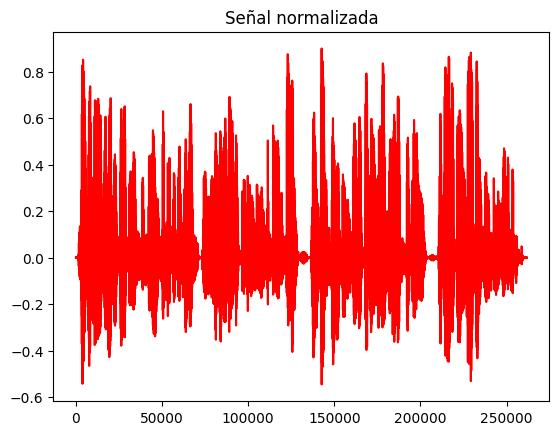

In [73]:
# Normalizamos la señal en el rango [-1, 1]
normalized_signal = 0.9 * original_signal / max(abs(original_signal))
plt.plot(np.array(range(0, len(normalized_signal))), normalized_signal, 'r')
plt.title("Señal normalizada")
plt.show()

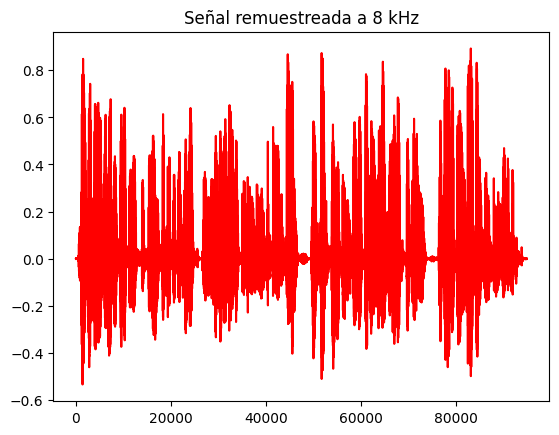

In [74]:
# Remuestreamos a 8 kHz
sampling_rate = 8000
signal = librosa.resample(normalized_signal, orig_sr=original_sampling_rate, target_sr=sampling_rate)

plt.plot(np.array(range(0, len(signal))), signal, 'r')
plt.title("Señal remuestreada a 8 kHz")
plt.show()

(512,)


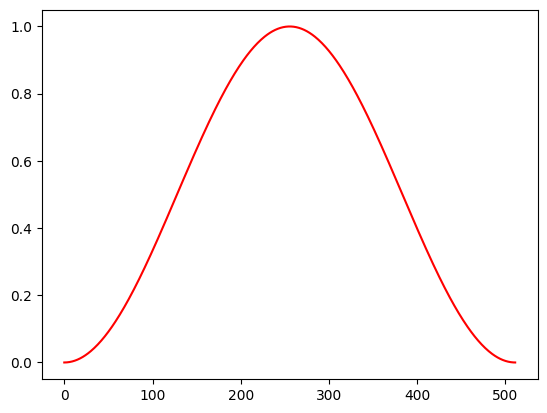

In [75]:
# Ahora bien, para poder calcular los MFCC de la señal, primero haremos un ventaneo usando la ventana
#  de Hanning

frame_length = 512 # La duración de la ventana será de 512 muestras
frame_step = frame_length//2 # Cada paso será de la mitad de las muestras (50% de overlap)
window = np.hanning(frame_length)
print(window.shape)

plt.plot(np.array(range(0, len(window))), window, 'r')

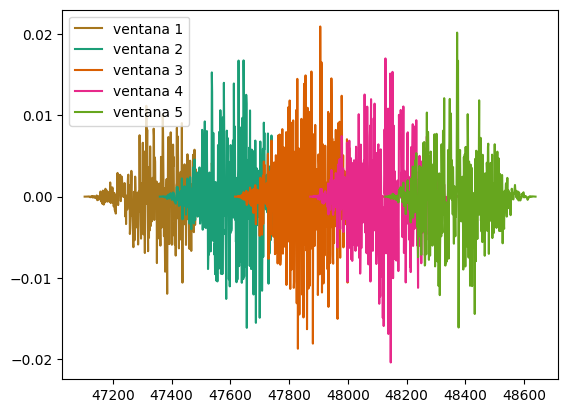

In [76]:
# Podemos hacer el mismo ventaneo que hicimos en LPC usando librosa, sólo que cambiamos de unidad

def create_overlapping_blocks(signal, window, step):
    framed_signal = librosa.util.frame(signal, frame_length=len(window), hop_length=step)
    _, num_blocks = framed_signal.shape

    windowed_signal = np.zeros_like(framed_signal)

    for i in range(num_blocks):
        windowed_signal[:, i] = framed_signal[:, i]*window
        
    return windowed_signal


blocks = create_overlapping_blocks(signal, window, frame_step)
_, num_blocks = blocks.shape

fig = plt.figure()
cmap = mpl.colormaps['Dark2']
ammount_to_plot = 5

window_time = np.array(range(frame_length))

for i in range(int(num_blocks//2),int((num_blocks//2) + ammount_to_plot)):
    offset = i * frame_step
    color = cmap(((1/ammount_to_plot)*i)%1)
    plt.plot(window_time + offset, blocks[:, i], label=f"ventana {1+i-num_blocks//2}", color=color)
    plt.legend()

In [77]:
# Luego, implementaremos unas funciones de conversión entre mel y hz

def hz_to_mel(hz):
    return 2595 * np.log10(1 + hz / 700)

def mel_to_hz(mel):
    return 700 * (10**(mel / 2595) - 1)

print("500 hz = ", hz_to_mel(500), "mel")

500 hz =  607.44591965659 mel


In [78]:
# Calculamos los filterbanks de Mel

def mel_filter_banks(n_filters, fft_size, sampling_rate):
    low_mel = hz_to_mel(0)
    high_mel = hz_to_mel(sampling_rate // 2)
    mel_points = np.linspace(low_mel, high_mel, n_filters + 2)
    hz_points = mel_to_hz(mel_points)
    bin_points = np.floor((fft_size + 1) * hz_points / sampling_rate).astype(int)

    filter_banks = np.zeros((n_filters, int(fft_size // 2 + 1)))
    for i in range(1, n_filters + 1):
        filter_banks[i - 1, bin_points[i - 1]: bin_points[i]] = \
            (np.arange(bin_points[i - 1], bin_points[i]) - bin_points[i - 1]) / \
                (bin_points[i] - bin_points[i - 1])
        filter_banks[i - 1, bin_points[i]: bin_points[i + 1]] = \
            (bin_points[i + 1] - np.arange(bin_points[i], bin_points[i + 1])) / \
                (bin_points[i + 1] - bin_points[i])
    
    return filter_banks

n_filters = 26

filter_banks = mel_filter_banks(n_filters, frame_length, sampling_rate)

print(filter_banks)


[[0.         0.33333333 0.66666667 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.0952381  0.04761905 0.        ]]


[[-4.22695707e+01 -3.36867437e+01 -2.55320785e+01 ... -3.08510904e+01
  -3.96908931e+01 -4.35371707e+01]
 [ 6.12222187e+00  1.66848332e+01  1.97128231e+01 ...  1.40439180e+01
   8.96645175e+00  8.03447662e+00]
 [ 3.59101306e+00  8.15265841e+00  7.42579080e+00 ...  5.96154292e+00
   4.05819554e+00  2.52796996e+00]
 ...
 [ 9.22686140e-01 -1.03323462e+00 -1.01356717e+00 ... -2.93338172e-02
   1.47999767e+00  1.92762826e-01]
 [ 9.91889783e-01 -7.72703588e-01 -9.95728438e-01 ... -5.45678751e-01
   7.71214359e-01  1.35116186e+00]
 [ 5.24432660e-01 -7.01534121e-01 -1.28082376e+00 ... -6.39272873e-01
   1.01549762e+00  4.71607356e-01]]


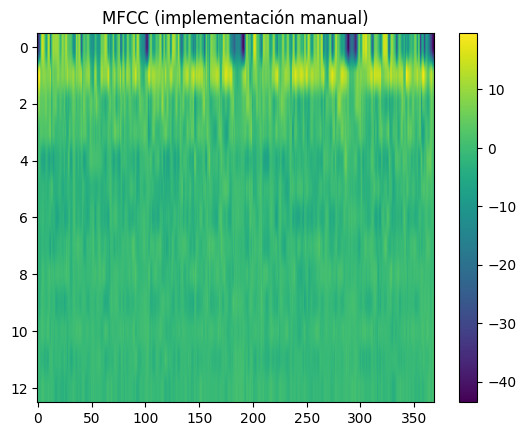

In [79]:
# Con todo esto, la MFCC la podemos calcular de la siguiente manera
# El paso en este caso lo definiremos siempre como la mitad

def mfc(signal, sampling_rate, n_filters=26, n_coeffs=13, fft_size=512):
    windowed_signal = create_overlapping_blocks(signal, np.hanning(fft_size), fft_size//2)
    
    magnitude_spectrogram = np.abs(np.fft.rfft(windowed_signal, axis=0)) ** 2

    filter_banks = mel_filter_banks(n_filters, fft_size, sampling_rate)
    
    # Aplicar filtros de Mel
    mel_spectrogram = np.dot(filter_banks, magnitude_spectrogram)
    mel_spectrogram = np.log(mel_spectrogram + 1e-10)

    # DCT para obtener MFCC
    mfccs = dct(mel_spectrogram, type=2, norm='ortho', axis=0)[:n_coeffs, :]
    
    return mfccs

mfccs = mfc(signal, sampling_rate)
print(mfccs)

plt.imshow(mfccs, aspect='auto')
plt.title("MFCC (implementación manual)")
plt.colorbar()
plt.show()

[[-4.95088989e+02 -2.41967865e+02 -6.76732483e+01 ... -3.02842896e+02
  -4.40961182e+02 -5.17955688e+02]
 [ 9.80287323e+01  7.64371109e+01  6.28390045e+01 ...  9.50363846e+01
   1.13628143e+02  6.74470749e+01]
 [ 6.66513062e+01  3.80789642e+01  3.49605942e+01 ... -1.78088226e+01
   2.48688965e+01  4.33942947e+01]
 ...
 [-1.55914755e+01  1.29336703e+00  5.73655796e+00 ...  3.53797078e-02
  -8.08128166e+00 -3.45020247e+00]
 [-1.66157913e+01 -1.56551590e+01 -1.03038712e+01 ... -1.08218050e+01
  -6.27412891e+00 -3.36244988e+00]
 [-1.49959736e+01 -5.52414989e+00  3.50503922e+00 ... -8.73736000e+00
  -7.83783054e+00 -3.34807348e+00]]


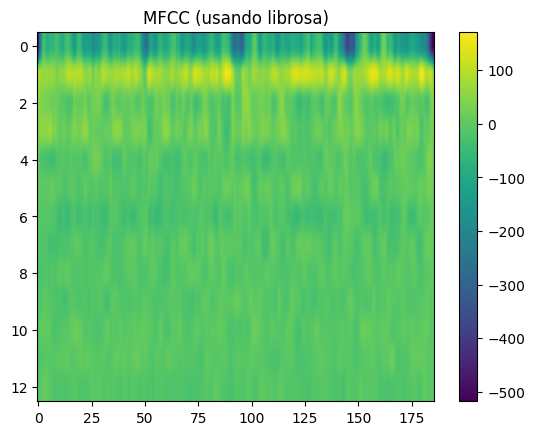

In [80]:
# Implementación de librosa

def mfcc_librosa(signal, sampling_rate, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=signal, sr=sampling_rate, n_mfcc=n_mfcc)
    return mfccs

mfccs_librosa = mfcc_librosa(signal, sampling_rate)
print(mfccs_librosa)

plt.imshow(mfccs_librosa, aspect='auto')
plt.title("MFCC (usando librosa)")
plt.colorbar()
plt.show()